### Instituto Tecnológico de Costa Rica (ITCR)
#### Escuela de Computación
#### Curso: Inteligencia Artificial
        
#### Tercera tarea programada 2023-I
#### Profesora: María Auxiliadora Mora
#### Estudiante: Fabian Vives - 2018319257

## 1. Problema y Objetivo

El problema a resolver trata de la clasificación de imágenes utilizando una red neuronal profunda basada en capas convolucionales. Se trabaja con el conjunto de datos "Birds 525 Species", que contiene imágenes de aves de 525 especies diferentes. El objetivo es entrenar la red para clasificar con precisión las imágenes y asignarles las etiquetas correctas de especies.

## 2. Referencia de los datos

En este ejercicio se utiliza el conjunto de datos Birds 525 Species. Consta de 39.982 imágenes de 525 especies de aves. 

El conjunto de datos está disponible en: https://www.kaggle.com/gpiosenka/100-bird-species

## 3. Exploracion de los Datos

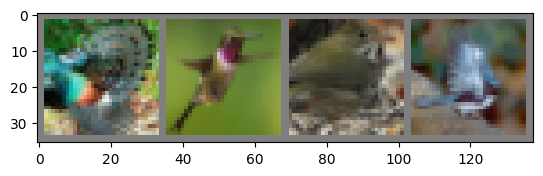

OCELLATED TURKEY AMETHYST WOODSTAR OVENBIRD BLACK THROATED WARBLER


In [13]:
# Importar bibliotecas necesarias
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader, TensorDataset



# Definir la transformación para cambiar el tamaño y normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((32, 32)),    # Resize the input images to 32x32
    transforms.ToTensor(),          # Convert the images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # Normalize the images with mean and standard deviation
])

# Cargar el conjunto de datos "Birds 525 Species" y aplicar la transformación
train_dataset = torchvision.datasets.ImageFolder(root="/mnt/c/Users/fvive/Desktop/SEG1/train", transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root="/mnt/c/Users/fvive/Desktop/SEG1/test", transform=transform)

# Definir los data loaders (cargadores de datos)
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    # Mezclar los datos de entrenamiento
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    # No Mezclar los datos de entrenamiento

# Definir el nombre de las clases
class_names = train_dataset.classes

# Mostrar algunas imágenes de muestra
def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar los datos de las imagenes
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    # Reorgannizar las dimensiones de las imagenes
    plt.show()

# Obtener datos de entrenamiento
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Mostrar las imágenes de muestra con sus etiquetas correspondientes

# Mostrar las primeras 4 imágenes del lote
imshow(torchvision.utils.make_grid(images[:4]))

# Imprime las etiquetas correspondientes de las primeras 4 imágenes
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))    # Print the corresponding labels of the first 4 images


## 4. Estadistica de los datos

Train Class Counts: [163. 180. 179. 135. 154. 137. 155. 187. 179. 132. 161. 165. 166. 150.
 179. 170. 158. 193. 164. 133. 155. 179. 139. 147. 187. 130. 134. 144.
 154. 153. 150. 139. 150. 139. 154. 153. 152. 188. 164. 156. 141. 220.
 190. 187. 154. 190. 164. 168. 141. 136. 137. 165. 150. 160. 152. 132.
 137. 165. 163. 194. 166. 153. 168. 158. 132. 136. 132. 143. 160. 142.
 144. 154. 151. 142. 156. 172. 132. 162. 131. 181. 173. 155. 164. 165.
 163. 145. 135. 188. 156. 133. 137. 168. 134. 144. 153. 155. 173. 195.
 170. 185. 167. 186. 198. 150. 157. 154. 160. 152. 154. 183. 177. 192.
 154. 163. 184. 155. 143. 160. 155. 177. 162. 152. 160. 161. 197. 160.
 185. 154. 133. 149. 155. 137. 133. 162. 213. 160. 180. 163. 153. 137.
 132. 170. 165. 144. 162. 141. 167. 162. 162. 161. 182. 161. 163. 166.
 177. 172. 139. 177. 157. 133. 161. 161. 141. 196. 144. 144. 135. 139.
 160. 155. 152. 142. 163. 152. 164. 181. 156. 197. 154. 198. 163. 162.
 138. 137. 233. 159. 136. 203. 146. 139. 148. 185. 166. 1

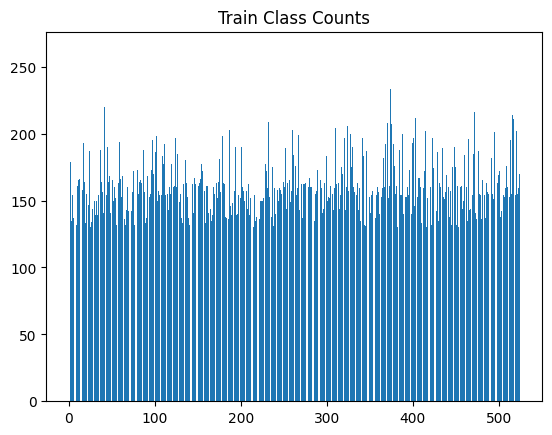

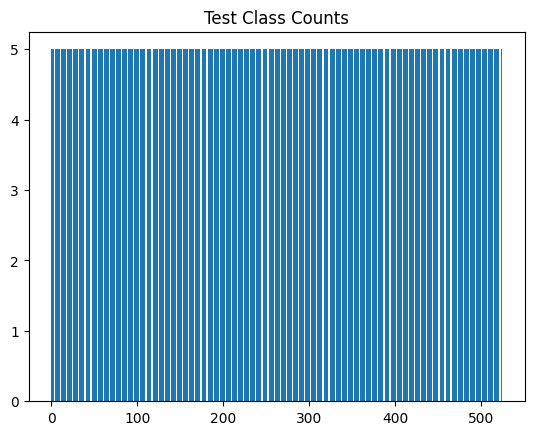

In [14]:
# Calculo de la cantidad de registros por clase para los conjuntos de datos de entrenamiento y prueba
train_class_counts = np.zeros(525)
test_class_counts = np.zeros(525)

# Recorre el train_loader e incrementa el conteo para cada etiqueta de clase
for data in train_loader:
    _, labels = data
    for label in labels:
        train_class_counts[label] += 1

# Recorre test_loader e incrementa el conteo para cada etiqueta de clase
for data in test_loader:
    _, labels = data
    for label in labels:
        test_class_counts[label] += 1

# Imprimir los conteos de clase para los conjuntos de datos de entrenamiento y prueba
print("Train Class Counts:", train_class_counts)
print("Test Class Counts:", test_class_counts)

# Graficar un histograma de los conteos de clases
plt.bar(np.arange(525), train_class_counts)     # Crear gráfico de barras de los recuentos de clases de entrenamiento
plt.title('Train Class Counts')                 # Establecer titulo
plt.show()                                      # Mostrar grafico

plt.bar(np.arange(525), test_class_counts)      # Crear gráfico de barras de los recuentos de clases de prueba
plt.title('Test Class Counts')                  # Establecer titulo
plt.show()                                      # Mostrar grafico

## 5. Definir la Red Convolucional

In [15]:
# Importar las librerias necesarias
import torch.nn as nn
import torch.nn.functional as F

# Definicion de la arquitectura ConvNet usando la clase nn.Module de PyTorch
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Definir las capas convolucionales con 16, 32 y 64 filtros
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Definir una capa de agrupación máxima con tamaño  2x2 y stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Definir las capas  conectadas con 512 y 525 neuronas de salida
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 525)

    def forward(self, x):
        # Aplicra las capas convolucionales la activación de ReLU y la agrupación máxima
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Reformar el tensor de salida a un tensor 1D
        x = x.view(-1, 64 * 4 * 4)
        # Aplicar las capas conectadas y la activación de ReLU
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instanciar la convNet
net = ConvNet()

## 6. Definicion de los hiper-parámetros de entrenamiento

In [16]:
# Importar bibliotecas necesarias
import torch.optim as optim
import torch.nn as nn

# Definir la función de pérdida (criterion) que se utilizará para el entrenamiento
criterion = nn.CrossEntropyLoss()

# Definir el optimizador que se usará para actualizar los parámetros de la red neuronal
optimizer = optim.Adam(net.parameters(), lr=0.001)

## 7. Separacion de las muestras en datos de entrenamiento y validación y entrenamiento

In [9]:
# Dividir los datos en conjuntos de entrenamiento y validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Crear cargadores de datos para los conjuntos de entrenamiento y validación
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Entrenar el modelo, numero de iterancion de los datos de entrenamiento
num_epochs = 20

# Creacion de listas para almacenar la pérdida y precisión de entrenamiento y validación para cada época
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    # Inicializar variables para realizar un seguimiento de la pérdida de entrenamiento y la precisión
    running_train_loss = 0.0
    running_train_total = 0
    running_train_correct = 0

    # Ciclar sobre los lotes en el conjunto de entrenamiento
    for i, data in enumerate(train_loader, 0):
        # Se obtienen las entradas y etiquetas para el lote
        inputs, labels = data

        # Cero a los gradientes para el optimizador
        optimizer.zero_grad()

        # Forward a través de la red
        outputs = net(inputs)

        # Calcular la pérdida
        loss = criterion(outputs, labels)

        # Backward a través de la red para calcular los gradientes
        loss.backward()

        # Actualizar los pesos y sesgos de la red usando el optimizador
        optimizer.step()

        # Seguimiento de la pérdida y la precisión del entrenamiento
        running_train_loss += loss.item()
        running_train_total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_train_correct += (predicted == labels).sum().item()

    # Inicizlizar las variables para realizar un seguimiento de la pérdida de entrenamiento y la precisión para cada época
    running_val_loss = 0.0
    running_val_total = 0
    running_val_correct = 0

    # Evaluar el modelo en el conjunto de validación
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data

            # Forward a través de la red
            outputs = net(inputs)

            # Calcular perdida
            loss = criterion(outputs, labels)

            # Seguimiento de la pérdida y la precisión del entrenamiento
            running_val_loss += loss.item()
            running_val_total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_val_correct += (predicted == labels).sum().item()

    # Calcular la pérdida promedio de entrenamiento y validación para la época y se agregan a las listas de historial de pérdidas
    train_loss_history.append(running_train_loss / len(train_loader))
    val_loss_history.append(running_val_loss / len(val_loader))

    # Calcular la precisión de entrenamiento y validación para la época y se agregan a las listas de historial de precisión
    train_acc = running_train_correct / running_train_total
    val_acc = running_val_correct / running_val_total
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    # Se imprime la pérdida, precisión de entrenamiento  y validación para la época
    print("Epoch: %d, Train Loss: %.3f, Val Loss: %.3f, Train Acc: %.3f, Val Acc: %.3f" % (epoch+1, train_loss_history[-1], val_loss_history[-1], train_acc_history[-1], val_acc_history[-1]))

Epoch: 1, Train Loss: 5.251, Val Loss: 4.402, Train Acc: 0.053, Val Acc: 0.126
Epoch: 2, Train Loss: 3.846, Val Loss: 3.602, Train Acc: 0.206, Val Acc: 0.249
Epoch: 3, Train Loss: 3.188, Val Loss: 3.230, Train Acc: 0.315, Val Acc: 0.312
Epoch: 4, Train Loss: 2.783, Val Loss: 2.992, Train Acc: 0.386, Val Acc: 0.359
Epoch: 5, Train Loss: 2.490, Val Loss: 2.899, Train Acc: 0.439, Val Acc: 0.378
Epoch: 6, Train Loss: 2.258, Val Loss: 2.796, Train Acc: 0.482, Val Acc: 0.402
Epoch: 7, Train Loss: 2.067, Val Loss: 2.779, Train Acc: 0.517, Val Acc: 0.411
Epoch: 8, Train Loss: 1.901, Val Loss: 2.732, Train Acc: 0.549, Val Acc: 0.425
Epoch: 9, Train Loss: 1.760, Val Loss: 2.712, Train Acc: 0.579, Val Acc: 0.437
Epoch: 10, Train Loss: 1.635, Val Loss: 2.758, Train Acc: 0.603, Val Acc: 0.435
Epoch: 11, Train Loss: 1.527, Val Loss: 2.808, Train Acc: 0.625, Val Acc: 0.434
Epoch: 12, Train Loss: 1.422, Val Loss: 2.897, Train Acc: 0.643, Val Acc: 0.436
Epoch: 13, Train Loss: 1.323, Val Loss: 2.897, Tr

## 8. Evaluar el modelo

In [10]:
# Importar librerias necesarias
from sklearn.metrics import confusion_matrix, classification_report

# Establecer la red neuronal para evaluar el modo
net.eval()

# Inicializar las variables para realizar un seguimiento de la pérdida y la precisión de las pruebas
test_loss = 0.0
test_total = 0
test_correct = 0

# Inicializar las listas para almacenar la verdad del terreno y las etiquetas predichas para el conjunto de prueba
y_true = []
y_pred = []

# Evaluar el modelo en el conjunto de prueba
with torch.no_grad():
    for data in test_loader:
        # Se obtienen las entradas y etiquetas para el lote
        inputs, labels = data

        # Forwaed a través de la red
        outputs = net(inputs)

        # Calcular perdida
        loss = criterion(outputs, labels)

        # Registro de la pérdida y precisión de la prueba en ejecución
        test_loss += loss.item()
        test_total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

        # Agregar las etiquetas reales y predichas para el lote a las listas
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Calcular la pérdida de prueba promedio y la precisión
test_loss /= len(test_loader)
test_acc = test_correct / test_total

# Imprimir la pérdida de prueba y la de precisión
print("Test Loss: %.3f, Test Accuracy: %.3f" % (test_loss, test_acc))

# Imprimir el informe de clasificación y la matriz de confusión
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=1))
print(confusion_matrix(y_true, y_pred))

Test Loss: 2.616, Test Accuracy: 0.530
                               precision    recall  f1-score   support

              ABBOTTS BABBLER       0.50      0.20      0.29         5
                ABBOTTS BOOBY       0.25      0.20      0.22         5
   ABYSSINIAN GROUND HORNBILL       0.33      0.20      0.25         5
        AFRICAN CROWNED CRANE       0.50      0.60      0.55         5
       AFRICAN EMERALD CUCKOO       1.00      0.60      0.75         5
            AFRICAN FIREFINCH       0.60      0.60      0.60         5
       AFRICAN OYSTER CATCHER       0.50      0.60      0.55         5
        AFRICAN PIED HORNBILL       1.00      0.40      0.57         5
          AFRICAN PYGMY GOOSE       0.38      1.00      0.56         5
                    ALBATROSS       0.33      0.40      0.36         5
               ALBERTS TOWHEE       0.38      0.60      0.46         5
         ALEXANDRINE PARAKEET       0.50      0.40      0.44         5
                ALPINE CHOUGH       0

## 9. Curva de error

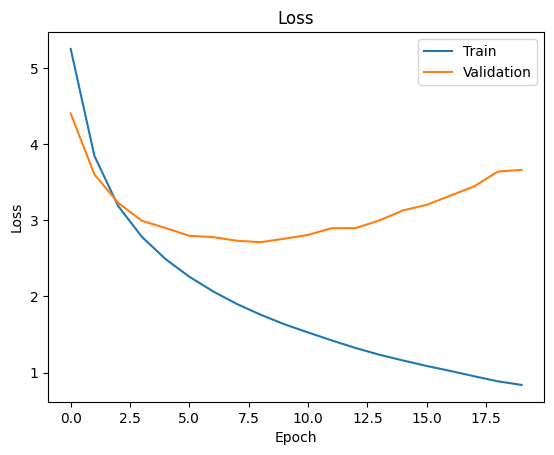

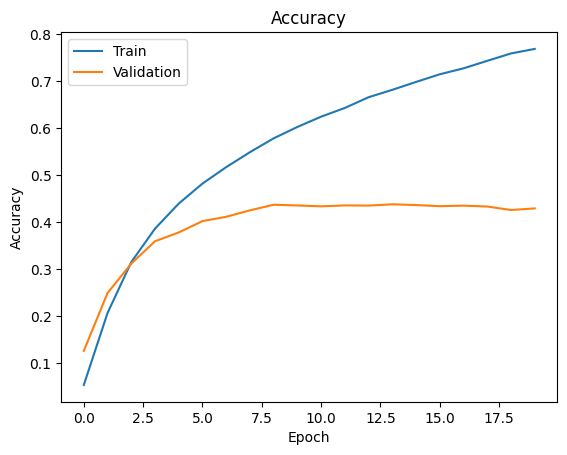

In [17]:
import matplotlib.pyplot as plt

# Graficar la pérdida de entrenamiento y validación
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar la precisión de entrenamiento y validación
plt.plot(train_acc_history, label='Train')
plt.plot(val_acc_history, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Al monitorear la curva de error de pérdida, la curva de error de precisión, y tomar medidas para abordar el sobreajuste o el ajuste insuficiente según sea necesario, se puede asegurar de que el modelo pueda generalizarse bien a nuevos datos y funcionar bien en aplicaciones del mundo real.

## 10. Analisis de Resultados

Para obtener una evaluación más precisa del rendimiento del modelo en datos nuevos, se puede resultar beneficioso ampliar el tamaño del conjunto de validación. 

Se pueden utilizar técnicas como la regularización o la detención anticipada para combatir el sobreajuste evitando que el modelo se vuelva demasiado complejo, resultando en la mejora de sus capacidades de generalización.

Para obtener una evaluación más precisa del rendimiento real del modelo en datos nuevos, se puede resultar beneficioso ampliar el tamaño del conjunto de validación o tambien lo siguiente:

Aumento de datos: para que los datos sean más variables y evitar el sobreajuste, se puede utilizar técnicas de aumento de datos. El recorte, el volteo y la rotación aleatorios de imágenes son algunas de las técnicas frecuentes de aumento de datos.

Transferencia de aprendizaje: Se puede comenzar con una red neuronal que ya ha sido entrenada y luego perfeccionarla utilizando datos de nuestro conjunto de datos. Si solo se tiene una pequeña cantidad de datos de entrenamiento, esto puede ayudar a que el modelo funcione mejor.

## 11. Conclusiones

1. La precisión del entrenamiento es significativamente mayor que la precisión de la validación, lo que sugiere que el modelo puede estar sobreajustado a los datos de entrenamiento y no generalizar bien los datos nuevos.

2. El rendimiento del modelo no es perfecto, aún es capaz de clasificar correctamente más de la mitad de las muestras de prueba, lo que puede ser suficiente para algunas aplicaciones según el caso de uso específico y los requisitos.

3. El modelo muestra alguna mejora en el rendimiento a lo largo de las épocas, el problema de sobreajuste debe abordarse para garantizar que el modelo pueda generalizarse bien a nuevos datos.

4. Las técnicas de regularización y aumento de datos pueden ayudar a prevenir el sobreajuste y mejorar el rendimiento del modelo.

## Referencias

P. G. Piórkowski, "100-bird-species," Kaggle, 2021. [Online]. Available: https://www.kaggle.com/gpiosenka/100-bird-species. [Accessed: 08-May-2023].

J. Brownlee, "A Gentle Introduction to the Adam Optimization Algorithm for Deep Learning," Machine Learning Mastery, 2017. [Online]. Available: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/. [Accessed: 08-May-2023].

Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner, "Gradient-based learning applied to document recognition," Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, 1998.